# Find the central QSO of CTIO Data in May 2017
==================================================================================================

- author : Jérémy Neveu
- date   : June 5th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

FindCentralStar


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [17]:
!ls ../OverScanRemove/trim_images

trim_20170605_004.fits trim_20170605_009.fits trim_20170605_014.fits
trim_20170605_005.fits trim_20170605_010.fits trim_20170605_016.fits
trim_20170605_006.fits trim_20170605_011.fits trim_20170605_017.fits
trim_20170605_007.fits trim_20170605_012.fits
trim_20170605_008.fits trim_20170605_013.fits


In [18]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=5
MAX_IMGNUMBER=8
object_name='QSO_3C273'
SelectTagRe='^trim_20170605_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170605_[0-9]+.fits$'
NBIMGPERLROW=2

### Output directory fot fits images

In [19]:
outputdir="./cut_fitsimages"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
print input_filelist[:5]

['trim_20170605_004.fits' 'trim_20170605_005.fits' 'trim_20170605_006.fits'
 'trim_20170605_007.fits' 'trim_20170605_008.fits']


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [25]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [26]:
MakeFileList()   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [31]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [32]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [33]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [34]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [35]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [36]:
#all_filt

## Show images
-----------------------

In [37]:
len(all_images)

4

In [69]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,10*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

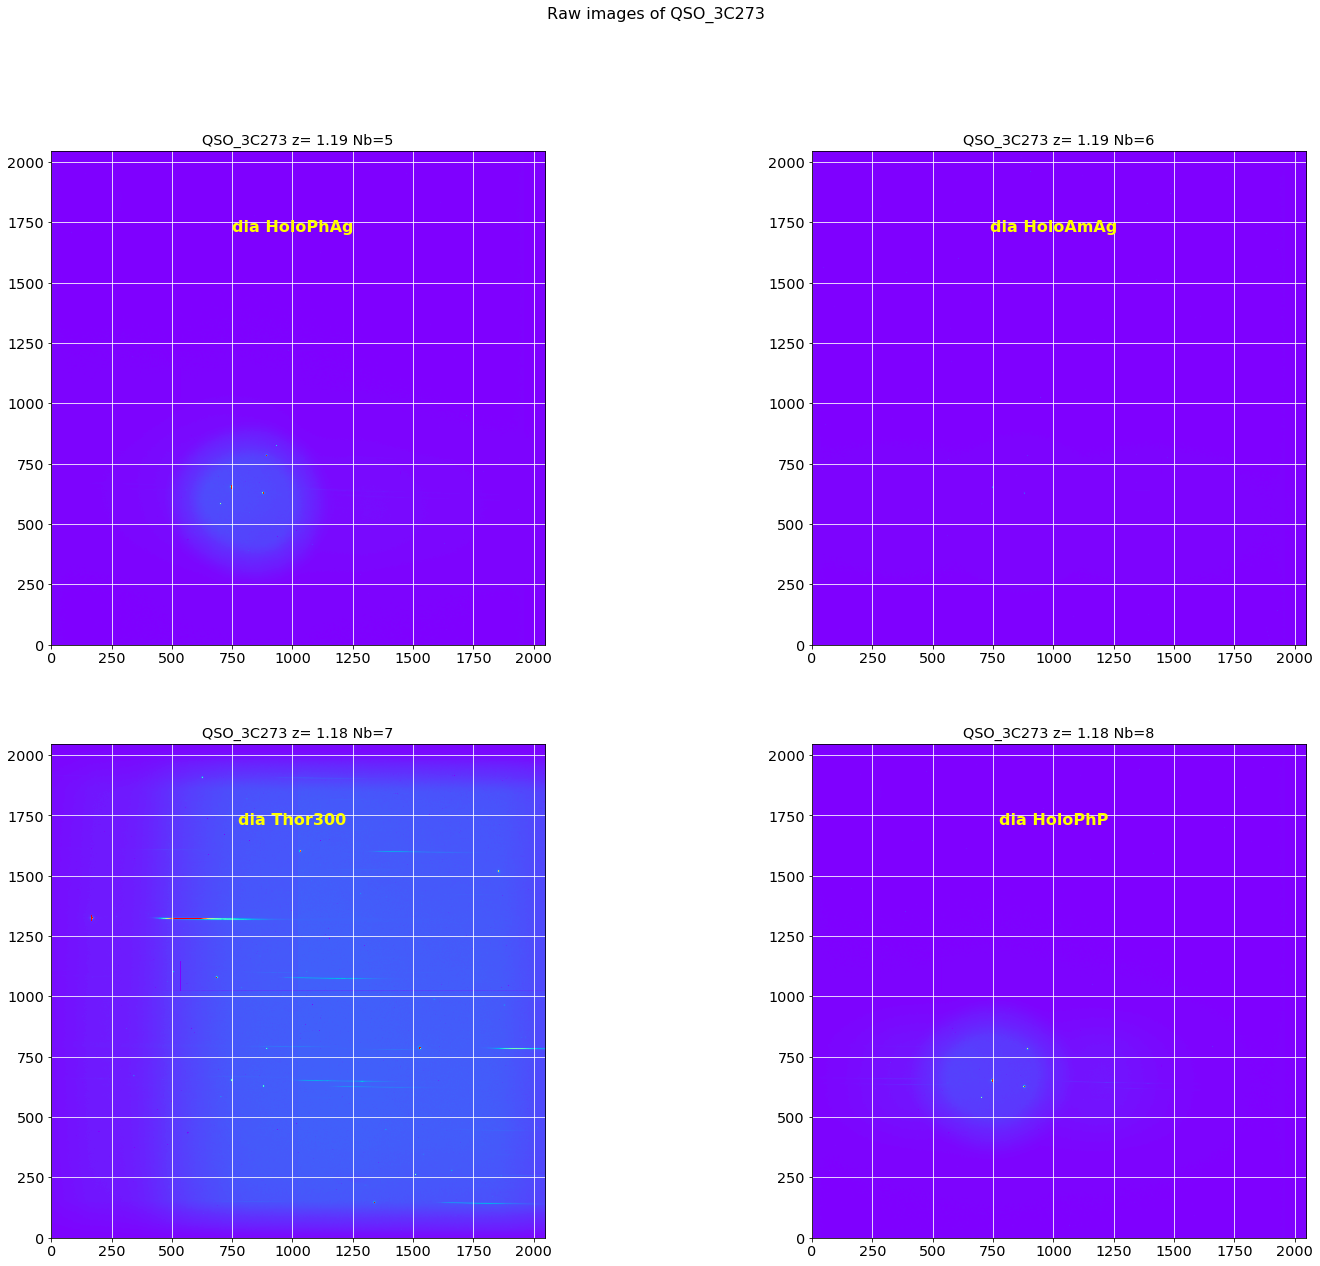

In [70]:
ShowRawImages()

### Find the star locations
----------------------------

In [86]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=5, threshold=20*std) # (JN) valeurs optimisées pour cette étude
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [87]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  387.243578911 30.0 1067.19730757


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 701.371401256 584.188069399 ... 44981.0 2.56015631706  -1.02066620777
  2 878.086840664 628.696158777 ... 60746.0 2.98233655244  -1.18639162849
  3 745.664041531 653.511512081 ... 60748.0 2.18469021509 -0.848474658857
  4 746.449294557 653.606945684 ... 60747.0 2.08858635758 -0.799631092281
  5 891.147478369 784.508602146 ... 60748.0  4.7045081294  -1.68128555833
----------------------------------------------------------------
1  mean, median, std =  30.4646556529 8.0 52.1315444858
 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 418.553013724 562.991416323 ...  1705.0 1.77982256645 -0.625941772274
  2  702.14116204 583.575048559 ...  1684.0 2.05578625718 -0.782444896247
  3 878.808952274 627.674725125 ... 15619.0 21.3923257348  -3.325

### Central star position

In [89]:
x_guess = 745
y_guess = 653
x_star = []
y_star = []

for s in img_sources :
    dist = 1e20
    k_star = -1
    for k in range(len(s)):
        x = s["xcentroid"][k]
        y = s["ycentroid"][k]
        test = (x-x_guess)**2 + (y-y_guess)**2
        if test < dist :
            dist = test
            k_star = k
    x_star.append(s["xcentroid"][k_star])
    y_star.append(s["ycentroid"][k_star])

In [90]:
# Default position
x0 = int(np.median(x_star))
y0 = int(np.median(y_star))
print x0,y0

746 652


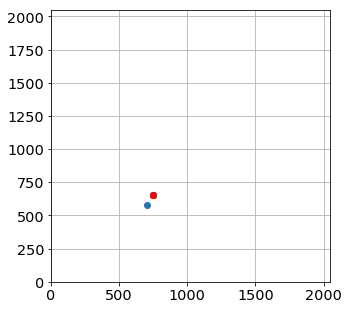

In [91]:
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x0,y0,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Cut the image

In [92]:
DeltaY=50
DeltaX=600

In [93]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    NBIMGPERLROW = 2
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,5*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',aspect='auto',origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

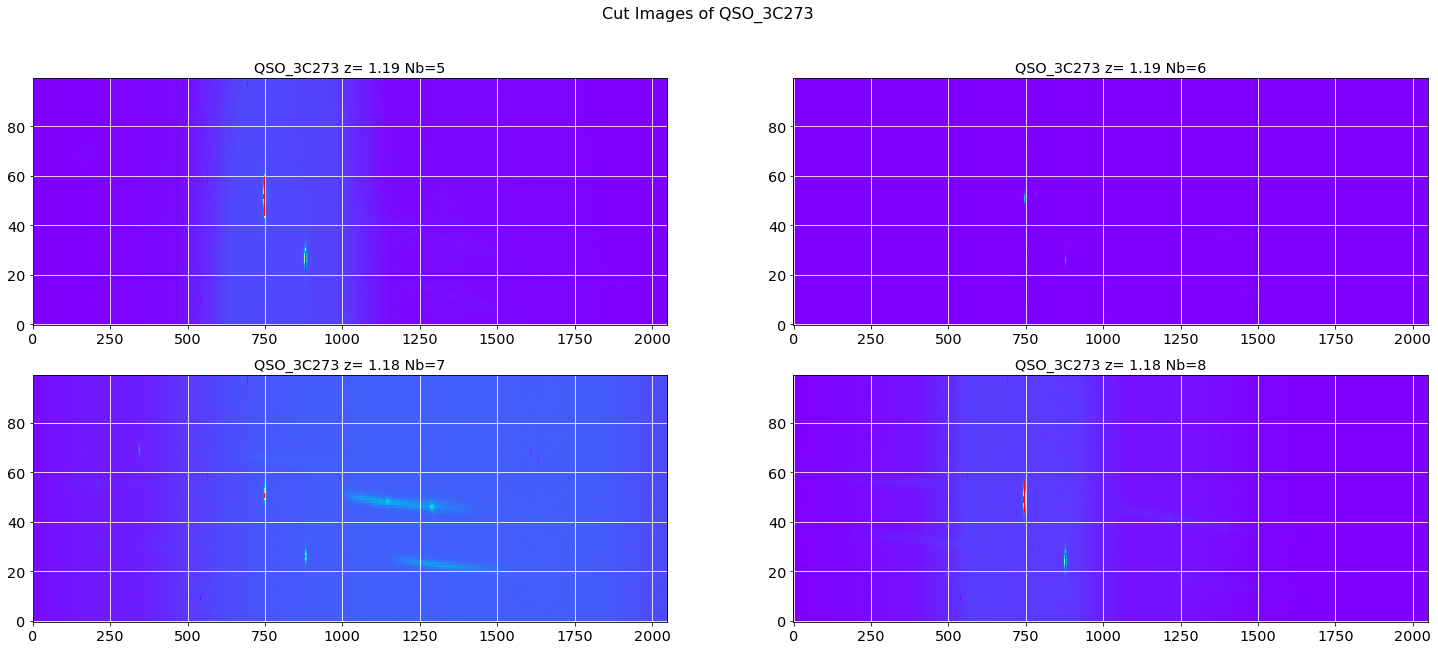

In [94]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,dir_top_images)

#### Example of cut image
-------------------------

In [95]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
#data[:,DeltaX-ws:DeltaX+ws]=0

In [96]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [97]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

27


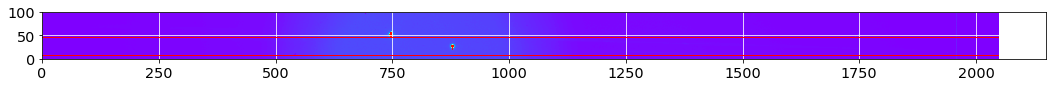

In [98]:
plt.figure(figsize=(18,18))
plt.imshow(data,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [99]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170605_005.fits
trim_20170605_006.fits
trim_20170605_007.fits
trim_20170605_008.fits


### Save outputfilename

In [100]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [101]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  1650240  6 jui 06:16 cut_fitsimages/cutimg_20170605_005.fits
-rw-r--r--  1 jneveu  staff  1650240  6 jui 06:16 cut_fitsimages/cutimg_20170605_006.fits
-rw-r--r--  1 jneveu  staff  1650240  6 jui 06:16 cut_fitsimages/cutimg_20170605_007.fits
-rw-r--r--  1 jneveu  staff  1650240  6 jui 06:16 cut_fitsimages/cutimg_20170605_008.fits
